In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import difflib
from collections import Counter
%matplotlib inline

In [2]:
#code from https://stackoverflow.com/questions/21504319/python-3-csv-file-giving-unicodedecodeerror-utf-8-codec-cant-decode-byte-err
#used to determine encoding needed to read csv
import pkgutil
import encodings
import os

def all_encodings():
    modnames = set([modname for importer, modname, ispkg in pkgutil.walk_packages(
        path=[os.path.dirname(encodings.__file__)], prefix='')])
    aliases = set(encodings.aliases.aliases.values())
    return modnames.union(aliases)

text = b'\xa3'
for enc in all_encodings():
    try:
        msg = text.decode(enc)
    except Exception:
        continue
    if msg == '£':
        print('Decoding {t} with {enc} is {m}'.format(t=text, enc=enc, m=msg))

Decoding b'\xa3' with mac_turkish is £
Decoding b'\xa3' with cp1252 is £
Decoding b'\xa3' with charmap is £
Decoding b'\xa3' with iso8859_15 is £
Decoding b'\xa3' with mac_cyrillic is £


C:\Users\Jeff\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: unicode_internal codec has been deprecated
  app.launch_new_instance()


Decoding b'\xa3' with mac_romanian is £
Decoding b'\xa3' with mac_centeuro is £
Decoding b'\xa3' with mac_croatian is £
Decoding b'\xa3' with mac_roman is £
Decoding b'\xa3' with iso8859_1 is £
Decoding b'\xa3' with cp864 is £
Decoding b'\xa3' with iso8859_8 is £
Decoding b'\xa3' with mac_latin2 is £
Decoding b'\xa3' with cp1253 is £
Decoding b'\xa3' with raw_unicode_escape is £
Decoding b'\xa3' with latin_1 is £
Decoding b'\xa3' with cp1254 is £
Decoding b'\xa3' with palmos is £
Decoding b'\xa3' with iso8859_14 is £
Decoding b'\xa3' with iso8859_9 is £
Decoding b'\xa3' with cp1257 is £
Decoding b'\xa3' with cp1258 is £
Decoding b'\xa3' with mbcs is £
Decoding b'\xa3' with iso8859_13 is £
Decoding b'\xa3' with iso8859_3 is £
Decoding b'\xa3' with mac_iceland is £
Decoding b'\xa3' with iso8859_7 is £
Decoding b'\xa3' with cp1255 is £
Decoding b'\xa3' with cp1256 is £
Decoding b'\xa3' with unicode_escape is £


In [3]:
apc_df = pd.read_csv('WELLCOME_APCspend2013_forThinkful.csv', encoding='iso8859_15')

In [4]:
apc_df.dtypes

PMID/PMCID                                             object
Publisher                                              object
Journal title                                          object
Article title                                          object
COST (£) charged to Wellcome (inc VAT when charged)    object
dtype: object

In [5]:
apc_df.isna().sum()

PMID/PMCID                                             199
Publisher                                                0
Journal title                                            1
Article title                                            0
COST (£) charged to Wellcome (inc VAT when charged)      0
dtype: int64

In [6]:
#Since we are interested in grouping our findings by journal, the record with no journal title needs to be dropped
i = apc_df[apc_df['Journal title'].isna()].index
apc_df.drop(i, inplace=True)

In [7]:
apc_df.isna().sum()

PMID/PMCID                                             198
Publisher                                                0
Journal title                                            0
Article title                                            0
COST (£) charged to Wellcome (inc VAT when charged)      0
dtype: int64

In [8]:
#Let's find out how many different values we have for Journal title
pd.set_option('display.max_rows', 999)
apc_df['Journal title'].value_counts()

PLoS One                                                                                                                        92
PLoS ONE                                                                                                                        62
Journal of Biological Chemistry                                                                                                 48
Nucleic Acids Research                                                                                                          21
Proceedings of the National Academy of Sciences                                                                                 19
PLoS Neglected Tropical Diseases                                                                                                18
Human Molecular Genetics                                                                                                        18
Nature Communications                                                              

In [9]:
def remove_abbreviations(s):
    slist = list(s.split(' '))
    for i in range(len(slist)):
        if 'j' == slist[i] or 'jnl' == slist[i] or 'j.' == slist[i]:
            slist[i] = 'journal'
        elif 'clin' in slist[i]:
            slist[i] = 'clinical'
        elif '1' in slist[i]:
            slist[i] = 'one'
        elif 'behav' in slist[i]:
            slist[i] = 'behaviour'
        elif 'mol' == slist[i]:
            slist[i] = 'molecular'
        elif 'immunol' == slist[i]:
            slist[i] = 'immunology'
        elif '&' in slist[i]:
            slist[i] = 'and'
        elif 'plosone' == slist[i]:
            slist[i] = 'plos'
            slist.append('one')

    
    return " ".join(slist)
        

In [10]:
def standardize_column(df, col, name):
    '''Find variants and abbreviations of strings in column and make them standard
    :param df: df, data frame containing the column to be cleaned
    :param col: str, the name of the column to clean
    :param name: str, name for new column with standardized values
    :return df: df, data frame with the column standardized'''
    #Create columns that strip whitespace, turn all letters lowercase, get rid of 'the' and 'of', find abbreviations 
    #and counts of occurrences
    df['lower'] = df[col].apply(lambda x: str(x).strip().lower().replace('the ', '').replace('of ', ''))
    df['abr'] = df['lower'].apply(lambda x: ''.join(re.findall(r'\b([a-z])', x)))
    df['count'] = df[col].apply(lambda x: df[col].loc[df[col] == x].count())
    
    #Replace some abbreviations with the full word to make matching easier
    df['lower'] = df['lower'].apply(lambda x: remove_abbreviations(x))
    
    #Replace titles that are just abbreviations with longform
    abr_list = list(df['abr'].values)
    for title in df['lower'].values:
        if title in abr_list:
            new = df['lower'].loc[df['abr'] == title]
            df['lower'].replace(title, new, inplace=True)
            
    #Create a dictionary of non-standardized titles: standardized titles
    match_dict = {}
    for a in df['abr'].values:
        titles = df['lower'].loc[df['abr'] == a].values
        title_dict = Counter(titles)
        while title_dict:
            frequent = max(title_dict)
            matches = difflib.get_close_matches(frequent, title_dict.keys(), cutoff=0.8)
            for match in matches:
                match_dict[match] = frequent
                del title_dict[match]
                matches.pop(matches.index(match))
            
    #Create standardized columns and drop intermediaries
    df[name] = df['lower'].replace(match_dict.keys(), match_dict.values())
    df.drop(['lower', 'abr', 'count'], axis=1, inplace=True)
    
    return df    

In [11]:
new_df = standardize_column(apc_df, 'Journal title', 'standard_titles')
new_df['standard_titles'].value_counts()

plos one                                                                                                                  206
journal biological chemistry                                                                                               64
neuroimage                                                                                                                 29
nucleic acids research                                                                                                     26
plos genetics                                                                                                              24
plos pathogens                                                                                                             24
proceedings national academy sciences                                                                                      22
plos neglected tropical diseases                                                                                      

In [12]:
new_df['standard_titles'].replace('pnas', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('proceedings national academy sciences (pnas)', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('pnas usa', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('proceedings national academy sciences usa', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('pnas (proceedings national academy sciences united states america', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('plos  one', 'plos one', inplace=True)
new_df['standard_titles'].replace('journal biol chemistry', 'journal biological chemistry', inplace=True)
new_df['standard_titles'].replace('neuroimage: clinical', 'neuroimage', inplace=True)
new_df['standard_titles'].replace('plos', 'plos one', inplace=True)
new_df['standard_titles'].replace('nucleic acid research', 'nucleic acids research', inplace=True)
new_df['standard_titles'].replace('national academy sciences', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('one', 'plos one', inplace=True)
new_df['standard_titles'].replace('neurolmage', 'neuroimage', inplace=True)
new_df['standard_titles'].replace('proc natl acad sci u s a.', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('biological chemistry', 'journal biological chemistry', inplace=True)
new_df['standard_titles'].replace('journal biol chem', 'journal biological chemistry', inplace=True)
new_df['standard_titles'].replace('proceedings national academy sciences united states america', 'proceedings national academy sciences', inplace=True)
new_df['standard_titles'].replace('proceddings national academy sciences usa', 'proceedings national academy sciences', inplace=True)

In [13]:
new_df['standard_titles'].value_counts().nlargest(5)

plos one                                 213
journal biological chemistry              72
proceedings national academy sciences     40
neuroimage                                36
nucleic acids research                    29
Name: standard_titles, dtype: int64

In [14]:
cost_col = new_df['COST (£) charged to Wellcome (inc VAT when charged)'] 
dollar_list = list(np.where(cost_col.str.contains('\$')))
new_df['COST (£) charged to Wellcome (inc VAT when charged)'] = cost_col.str.replace('\$', '')
dollar_list

[array([ 178,  179,  180,  181,  182,  183,  337, 1598, 1599, 1600, 1601,
        1602, 1603], dtype=int64)]

In [17]:
new_df['COST (£) charged to Wellcome (inc VAT when charged)'].iloc[dollar_list[0]]

178        1674
179      1375.8
180        2010
181     1204.38
182      1254.6
183        1476
337      671.04
1599       1440
1600     1460.3
1601    1476.47
1602    1570.87
1603    1600.25
1604    1600.25
Name: COST (£) charged to Wellcome (inc VAT when charged), dtype: object

In [18]:
new_df['COST (£) charged to Wellcome (inc VAT when charged)'] = cost_col.str.replace('£', '')
new_df['COST (£) charged to Wellcome (inc VAT when charged)'] = cost_col.str.replace(',', '')

In [19]:
new_df['COST (£) charged to Wellcome (inc VAT when charged)'] = cost_col.astype(float)
new_df.dtypes

PMID/PMCID                                              object
Publisher                                               object
Journal title                                           object
Article title                                           object
COST (£) charged to Wellcome (inc VAT when charged)    float64
standard_titles                                         object
dtype: object

In [22]:
new_df['COST (£) charged to Wellcome (inc VAT when charged)'].iloc[dollar_list[0]] = new_df['COST (£) charged to Wellcome (inc VAT when charged)'].iloc[dollar_list[0]]/1.6
new_df.iloc[178]

C:\Users\Jeff\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


PMID/PMCID                                                                                    PMC3398262
Publisher                                                                                 BioMed Central
Journal title                                                                                BMC Biology
Article title                                          Detailed interrogation of trypanosome cell bio...
COST (£) charged to Wellcome (inc VAT when charged)                                              1046.25
standard_titles                                                                              bmc biology
Name: 178, dtype: object

In [23]:
new_df['COST (£) charged to Wellcome (inc VAT when charged)'].describe()

count      2126.000000
mean      24069.133060
std      146895.544047
min           0.000000
25%        1272.892500
50%        1882.970000
75%        2321.230000
max      999999.000000
Name: COST (£) charged to Wellcome (inc VAT when charged), dtype: float64

In [24]:
df_ = new_df[new_df['COST (£) charged to Wellcome (inc VAT when charged)'] < 150000]

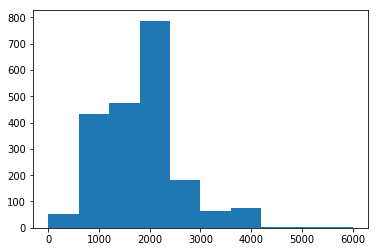

In [25]:
plt.hist(df_['COST (£) charged to Wellcome (inc VAT when charged)'])
plt.show()

In [26]:
df_['COST (£) charged to Wellcome (inc VAT when charged)'].describe()

count    2077.000000
mean     1818.659068
std       770.329931
min         0.000000
25%      1260.000000
50%      1851.150000
75%      2302.130000
max      6000.000000
Name: COST (£) charged to Wellcome (inc VAT when charged), dtype: float64

In [27]:
cost_by_journal = new_df[new_df['COST (£) charged to Wellcome (inc VAT when charged)'] < 150000].groupby('standard_titles')

In [28]:
cost_by_journal.mean()

,COST (£) charged to Wellcome (inc VAT when charged)
standard_titles,
academy nutrition and dietetics,2379.540000
acs chemical biology,1418.186000
acs chemical neuroscience,1186.800000
acs nano,668.140000
"acta crystallographica section d, biological crystallography",771.420000
acta crystallographica section d: biological crystallography,773.740000
acta crystallographica section f: structural biology and crystallization communications,796.635000
"acta crystallographica, section d",757.180000
acta crystallography d,774.190000
